In [ ]:
!pip install gensim
import gensim
from IPython.display import display
from collections import Counter
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.sparse import csr_matrix, hstack
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from datasets import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertTokenizerFast,
    DistilBertModel,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#CARGA DE BASE DE DATOS EN CRUDO

In [ ]:

# Cargamos y observamos la base de datos preprocesada en el otro código
df = pd.read_excel("BASEDATOS_REDUCIDA.xlsx")
df.head()

,title,text,label,lenguage,punctuation_count,uppercase_ratio,numerical_count,sentiment_polarity,title_len,text_len,total_len
0,Why The New Child Rape Case Filed Against Dona...,An anonymous Jane Doe filed a federal lawsuit ...,0,en,360,0.027302,52,0.136364,78,13772,13850
1,Comment on Cop’s Attempt to Abuse His Authorit...,Home / Badge Abuse / Cop’s Attempt to Abuse Hi...,1,en,68,0.027786,15,0.400000,115,3455,3570
2,Trump Got Another Totally Real Letter From A ...,Sarah Huckabee Sanders decided to once again s...,1,en,191,0.042403,148,0.225000,95,5094,5189
3,HILLARY OWNS THIS! How Clinton Brought Black A...,Even more reason to believe it s a good thing...,1,en,72,0.031963,36,-0.083333,77,2628,2705
4,Attack of the Clones translated into Chinese a...,Next Swipe left/right Attack of the Clones tra...,1,en,185,0.043142,100,0.125000,94,3755,3849


#1. Análisis exploratorio del conjunto de datos

##**1.1 Descripción general del dataset**

In [ ]:
print("Forma del dataset (filas, columnas):", df.shape)

print("\nTipos de datos:")
print(df.dtypes)

print("\nValores nulos por columna:")
print(df.isna().sum())

Forma del dataset (filas, columnas): (10000, 11)

Tipos de datos:
title                  object
text                   object
label                   int64
lenguage               object
punctuation_count       int64
uppercase_ratio       float64
numerical_count         int64
sentiment_polarity    float64
title_len               int64
text_len                int64
total_len               int64
dtype: object

Valores nulos por columna:
title                 0
text                  1
label                 0
lenguage              0
punctuation_count     0
uppercase_ratio       0
numerical_count       0
sentiment_polarity    0
title_len             0
text_len              0
total_len             0
dtype: int64


##**1.2 Estadísticas básicas y visualizaciones simples**



####   Distribución de clases (Real/Fake)




label
0    4200
1    5800
Name: count, dtype: int64


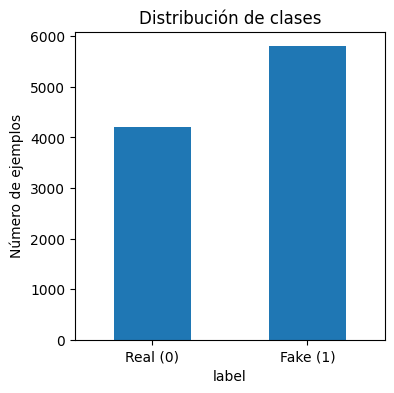

In [ ]:
# Buscamos ir contando el número de casos con etiqueta 0 (real) y 1 (fake), para tener una vista global de la distribución de clases. Buscamos que sean equilibradas, un número parecido de reales y falsos, para el buen funcionamiento del programa
class_counts = df["label"].value_counts().sort_index()
print(class_counts)
plt.figure(figsize=(4,4))
class_counts.plot(kind="bar")
plt.xticks([0,1], ["Real (0)", "Fake (1)"], rotation=0)
plt.ylabel("Número de ejemplos")
plt.title("Distribución de clases")
plt.show()



###Longitudes de texto




          title_len       text_len      total_len
count  10000.000000   10000.000000   10000.000000
mean      79.481800    5312.893100    5392.374900
std       26.833134    4749.697802    4747.510604
min        9.000000    2454.000000    2505.000000
25%       63.000000    3022.000000    3109.000000
50%       76.000000    4014.000000    4094.500000
75%       92.000000    6011.000000    6086.250000
max      277.000000  134206.000000  134263.000000


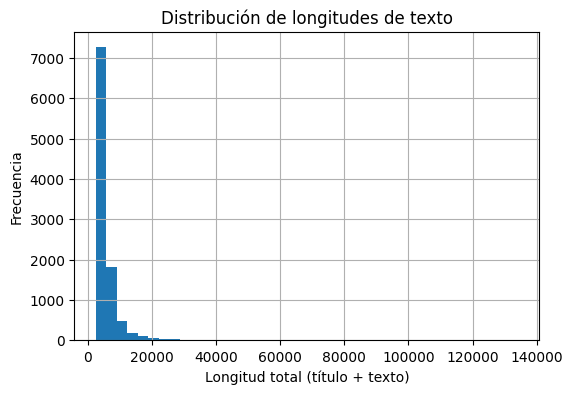

<Figure size 600x400 with 0 Axes>

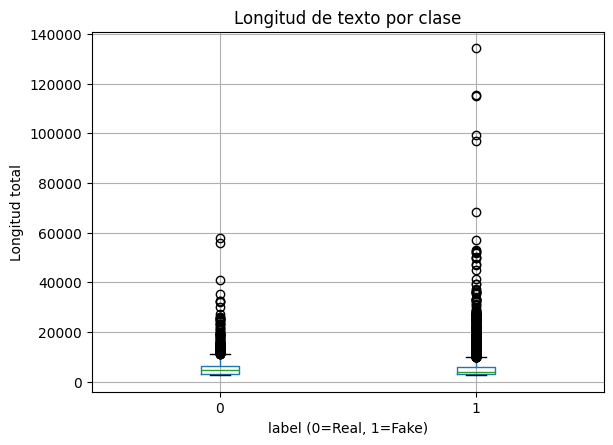

,punctuation_count,uppercase_ratio,numerical_count,sentiment_polarity
label,,,,
0,118.184762,0.032651,29.093095,0.051247
1,124.692241,0.036788,35.700862,-0.000623


In [ ]:
# Buscamos representar una visualización media de las longitudes del título, texto y combinadas de las 10000 muestras
print(df[["title_len", "text_len", "total_len"]].describe())

# Enseñamos una representación general de las longitudes mediante un histograma, viendo cuantas muestras hay con cada número de palabras
plt.figure(figsize=(6,4))
df["total_len"].hist(bins=40)
plt.xlabel("Longitud total (título + texto)")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes de texto")
plt.show()

# Comparación de las longitudes totales entre los textos reales y falsos
plt.figure(figsize=(6,4))
df.boxplot(column="total_len", by="label")
plt.xlabel("label (0=Real, 1=Fake)")
plt.ylabel("Longitud total")
plt.title("Longitud de texto por clase")
plt.suptitle("")
plt.show()

# Media del número de signos de puntuación, proporción de mayúsculas, cantidad de números y polaridad del sentimiento por cada etiqueta (real o falsa)
df[["label", "punctuation_count", "uppercase_ratio",
    "numerical_count", "sentiment_polarity"]].groupby("label").mean()


##**1.3 Análisis preliminar del texto**



###Palabras más frecuentes



In [ ]:
# Usamos la columna de texto original
TEXT_COL = "text"

# Obtenemos las 20 palabras más usadas en noticias reales, empezando por la obtención de los textos con etiqueta 0
real_series = df[df["label"] == 0][TEXT_COL].dropna().astype(str)

# Unimos todos los textos en un string
real_text_all = " ".join(real_series)

# Pasamos a minúsculas y separamos por espacios
real_tokens = real_text_all.lower().split()

# Contamos las frecuencias
real_counter = Counter(real_tokens)

# Obtenemos las 20 más frecuentes
top_real = real_counter.most_common(20)
print("Top 20 palabras en noticias REALES (label = 0):")
print(top_real)

# Obtenemos las 20 palabras más usadas en noticias falsas, mismo proceso que para las reales pero filtrando los textos con un label=1
fake_series = df[df["label"] == 1][TEXT_COL].dropna().astype(str)
fake_text_all = " ".join(fake_series)
fake_tokens = fake_text_all.lower().split()
fake_counter = Counter(fake_tokens)
top_fake = fake_counter.most_common(20)
print("\nTop 20 palabras en noticias FAKE (label = 1):")
print(top_fake)

Top 20 palabras en noticias REALES (label = 0):
[('the', 207955), ('to', 101637), ('of', 92249), ('a', 88081), ('and', 83406), ('in', 74749), ('that', 44675), ('on', 35441), ('for', 34324), ('is', 27936), ('he', 26132), ('with', 23716), ('was', 23285), ('as', 21903), ('said', 20486), ('his', 19086), ('it', 19034), ('by', 18151), ('has', 17373), ('at', 17089)]

Top 20 palabras en noticias FAKE (label = 1):
[('the', 286119), ('to', 143356), ('of', 135085), ('and', 123229), ('a', 102126), ('in', 89110), ('that', 70667), ('is', 58376), ('for', 44988), ('on', 37224), ('it', 32830), ('as', 31848), ('with', 31461), ('s', 29319), ('was', 29140), ('are', 27166), ('by', 26300), ('this', 26247), ('he', 26100), ('be', 25862)]




###Ejemplos por clase



In [ ]:
# Sacamos 3 ejemplos aleatorios de cada clase, para mostrarlos por pantalla
print("Ejemplos de noticias reales:")
display(df[df["label"] == 0][["title", "text"]].sample(3, random_state=0))

print("\nEjemplos de noticias falsas:")
display(df[df["label"] == 1][["title", "text"]].sample(3, random_state=1))

Ejemplos de noticias reales:


,title,text
7328,‘They’re Lies’: Melania Trump Rejects Women’s ...,"Melania Trump, who has been all but invisible ..."
8289,U.S. lawmakers fight White House transportatio...,WASHINGTON (Reuters) - The White House plan to...
6888,"FULL SPEECH: Theresa May Hails Globalism, Call...",British Prime Minister Theresa May used her sp...



Ejemplos de noticias falsas:


,title,text
3083,"Republican Stuns CNN Host, Wants To Starve Am...",As if the Republican Party couldn t possibly l...
3391,Trump’s Favorite News Channel Tries To Soothe...,"Yesterday, after the father of one of the UCLA..."
8825,"West Virginia Republicans Legalize Raw Milk, ...",Long may their heaves remind them of just how ...


### Nube de palabras

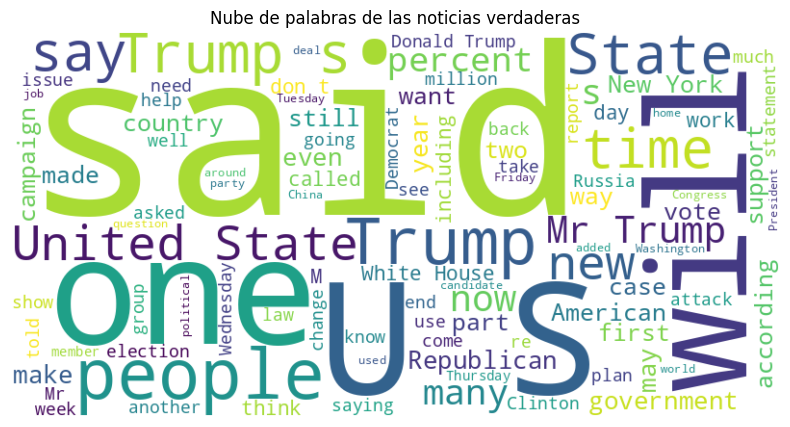

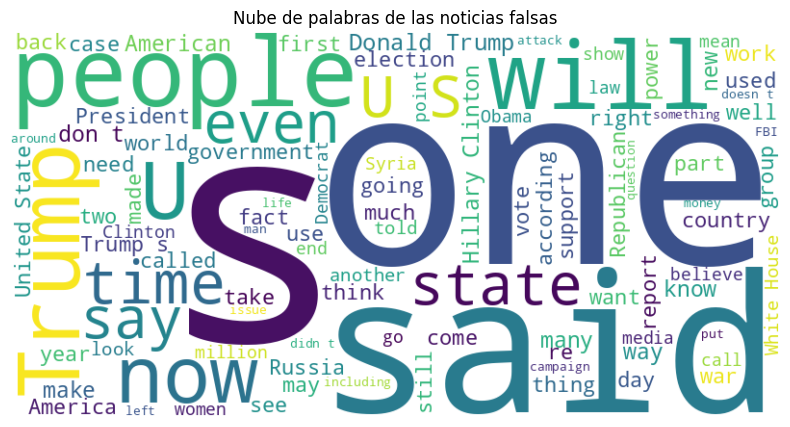

In [ ]:
# Nube de palabras de los textos verdaderos, juntando todos los textos verdaderos en una string y utilizando el WordCloud
real_texts = df[df["label"] == 0]["text"].dropna().astype(str)
real_text_combined = " ".join(real_texts)

wc_real = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate(real_text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wc_real, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de las noticias verdaderas")
plt.show()

# Nube de palabras de los textos falsos, mismo proceso que en el caso anterior
fake_texts = df[df["label"] == 1]["text"].dropna().astype(str)
fake_text_combined = " ".join(fake_texts)

wc_fake = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate(fake_text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wc_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de las noticias falsas")
plt.show()



##**1.4 Formulación de hipótesis iniciales sobre posibles relaciones entre desinformación y polarización.**



#**Hipótesis**

### **Hipótesis 1 — Posible mayor carga emocional en contenido desinformativo**  
Los textos que han sido etiquetados con label = 1 (Fake News) pueden estar situados en extremos más polarizados a nivel político (más próximos a -1 y 1), pudiendo ir relacionado con un mayor uso comentado de lenguaje sentimental, ya sea muy positivo o muy negativo.

### **Hipótesis 2 — Posible mayor uso de signos de puntuación y letras en mayúscula en textos falsos**  
Las noticias falsas (label = 1, Fake News) pueden tender a usar más signos de puntuación y letras en mayúscula. Esto lo relacionamos con estrategias de búsqueda de impacto en internet, en el que una noticia falsa suele buscar generar un texto llamativo para el espectador.

### **Hipótesis 3 — Posible exceso o reducción extrem en el número de palabras en textos falsos**  
Creemos que un texto falso puede tender a dos posibles caminos: buscar un impacto rápido en pocas palabras, queriendo que el espectador no cuestione en exceso la veracidad del texto, o una justificación demasiado extensa, intentando demostrar algo que no es verídico.

### **Hipótesis 4 — Posible mayor uso de datos numéricos en Fake News**  
Planteamos que las Fake News (label = 1) pueden tender a incluir más números y porcentajes que las noticias reales. Esto puede funcionar como una estrategia de pseudo-credibilidad: la presencia de cifras puede dar un sentimiento de credibilidad al texto, aunque en realidad carezca de fundamento.

#2. Representación vectorial del texto

##**2.0 Preprocesado de texto**

In [ ]:
# Vamos a realizar un prepocesado de texto, obteniendo únicamente palabras de importancia (transformando alguna, por ejemplo, formas verbales a infinitivo) y eliminando nexos, espaciadores sin información...
# Cargamos palabras típicas en inglés sin información y un lematizador
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Creamos una función que procese el texto. tal y como hemos comentado en la entrada
def preprocess_text(text):
    # Nos aseguramos que no sea NaN
    if pd.isna(text):
        return ""

    # Convertimos a minúsculas
    text = str(text).lower()

    # Tokenización
    tokens = word_tokenize(text)

    # Mantenemos solo tokens alfanuméricos
    tokens = [token for token in tokens if token.isalnum()]

    # Eliminamos la lista de palabras sin información en inglés que hemos importado antes
    tokens = [token for token in tokens if token not in stop_words]

    # Lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Reconstruimos como una string
    return " ".join(tokens)

# Ahora aplicamos la función anterior a todos los textos trabajados, y lo guardamos con el nombre "clean_text"
df["clean_text"] = df["text"].apply(preprocess_text)
df[["text", "clean_text"]].head()

,text,clean_text
0,An anonymous Jane Doe filed a federal lawsuit ...,anonymous jane doe filed federal lawsuit gop p...
1,Home / Badge Abuse / Cop’s Attempt to Abuse Hi...,home badge abuse cop attempt abuse authority f...
2,Sarah Huckabee Sanders decided to once again s...,sarah huckabee sander decided show everyone mu...
3,Even more reason to believe it s a good thing...,even reason believe good thing hillary clinton...
4,Next Swipe left/right Attack of the Clones tra...,next swipe attack clone translated chinese bac...


##**2.1 TF-IDF**

In [ ]:
# Seleccionamos la columna del texto procesado obtenido en el 2.0
TEXT_COL = "clean_text"

# Cargamos las etiquetas de los casos, para poder realizar una división de datos de forma estratificada
y = df["label"].values

# Dividimos en train / validation / test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df[TEXT_COL],
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text,
    y_train,
    test_size=0.20,
    random_state=42,
    stratify=y_train
)

print("Tamaños:")
print("Train:", len(X_train_text))
print("Validation:", len(X_val_text))
print("Test:", len(X_test_text))

# Vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=15000,     # tamaño del vocabulario
    ngram_range=(1,2),      # unigramas y bigramas
    min_df=5,               # ignorar palabras muy raras
    sublinear_tf=True       # suaviza frecuencia
)

# Ajustamos solo con el conjunto de entrenamiento
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

# Transformamos validación y test con el ajuste anterior
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print("Dimensión TF-IDF:", X_train_tfidf.shape)

# Añadimos características numéricas
numeric_cols = ["punctuation_count", "uppercase_ratio", "numerical_count", "sentiment_polarity"]

train_numeric = csr_matrix(df.loc[X_train_text.index, numeric_cols].values)
val_numeric   = csr_matrix(df.loc[X_val_text.index, numeric_cols].values)
test_numeric  = csr_matrix(df.loc[X_test_text.index, numeric_cols].values)

X_train_tfidf_all = hstack([X_train_tfidf, train_numeric])
X_val_tfidf_all   = hstack([X_val_tfidf, val_numeric])
X_test_tfidf_all  = hstack([X_test_tfidf, test_numeric])

print("TF-IDF + numéricas:", X_train_tfidf_all.shape)


# Guardamos las estructuras obtenidas para usarlas en el punto 4
tfidf_data = {
    "vectorizer": tfidf_vectorizer,
    "X_train": X_train_tfidf_all,
    "X_val": X_val_tfidf_all,
    "X_test": X_test_tfidf_all,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

Tamaños:
Train: 6400
Validation: 1600
Test: 2000
Dimensión TF-IDF: (6400, 15000)
TF-IDF + numéricas: (6400, 15004)


##**2.2 Word2Vec**

In [ ]:
# Seleccionamos el texto preprocesado
TEXT_COL = "clean_text"
y = df["label"].values

# Dividimos el dataset en tres partes: entrenamiento, validación y prueba
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df[TEXT_COL],
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text,
    y_train,
    test_size=0.20,
    random_state=42,
    stratify=y_train
)

# Imprimimos por pantalla el tamaño de cada uno de los conjuntos
print("Tamaños Word2Vec:")
print("Train:", len(X_train_text))
print("Validation:", len(X_val_text))
print("Test:", len(X_test_text))

# Convertimos el texto en listas de palabras --> tokens
df["tokens"] = df[TEXT_COL].apply(lambda x: x.split())

X_train_tokens = df.loc[X_train_text.index, "tokens"]
X_val_tokens   = df.loc[X_val_text.index, "tokens"]
X_test_tokens  = df.loc[X_test_text.index, "tokens"]

# Convertimos los tokens de entrenamiento en una lista de frases
sentences = X_train_tokens.tolist()

# Creamos el modelo Word2Vec, el cual aprende embbedings para cada palabra
ft_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=3,
    min_count=2,
    workers=4,
    epochs=5
)

# Cada texto se representa como el promedio de los embbedings de sus palabras, obteniendo un vector fijo por cada texto
def vectorize(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_train_w2v = np.vstack([vectorize(tokens, ft_model) for tokens in X_train_tokens])
X_val_w2v   = np.vstack([vectorize(tokens, ft_model) for tokens in X_val_tokens])
X_test_w2v  = np.vstack([vectorize(tokens, ft_model) for tokens in X_test_tokens])

# Imprimimos los embeddings completos para los primeros 5 textos
print("\nEmbeddings de Word2Vec para el conjunto de entrenamiento (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_train_w2v[i]}")

print("\nEmbeddings de Word2Vec para el conjunto de validación (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_val_w2v[i]}")

print("\nEmbeddings de Word2Vec para el conjunto de prueba (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_test_w2v[i]}")

# Añadimos algunas caracteristicas numericas adicionales a los vectores: puntuación, mayúsculas, etc
numeric_cols = ["punctuation_count", "uppercase_ratio", "numerical_count", "sentiment_polarity"]

train_numeric = csr_matrix(df.loc[X_train_text.index, numeric_cols].values)
val_numeric   = csr_matrix(df.loc[X_val_text.index, numeric_cols].values)
test_numeric  = csr_matrix(df.loc[X_test_text.index, numeric_cols].values)

# Convertimos las matrices dispersas a matrices densas (usamos .toarray() para obtener los valores completos)
X_train_w2v_all = hstack([csr_matrix(X_train_w2v), train_numeric]).toarray()
X_val_w2v_all   = hstack([csr_matrix(X_val_w2v), val_numeric]).toarray()
X_test_w2v_all  = hstack([csr_matrix(X_test_w2v), test_numeric]).toarray()

# Imprimimos los embeddings completos combinados con las características numéricas para los 5 primeros textos
print("\nEmbeddings de Word2Vec + características numéricas para el conjunto de entrenamiento (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_train_w2v_all[i]}")

print("\nEmbeddings de Word2Vec + características numéricas para el conjunto de validación (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_val_w2v_all[i]}")

print("\nEmbeddings de Word2Vec + características numéricas para el conjunto de prueba (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_test_w2v_all[i]}")

# Por último, guardamos todo en una estructura de datos para luego usarla para entrenar modelos de clasificación posteriores
w2v_data = {
    "model": ft_model,
    "X_train": X_train_w2v_all,
    "X_val": X_val_w2v_all,
    "X_test": X_test_w2v_all,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}


Tamaños Word2Vec:
Train: 6400
Validation: 1600
Test: 2000

Embeddings de Word2Vec para el conjunto de entrenamiento (primeros 5 textos):
Documento 1: [-0.53705657 -0.08520991 -0.09127814  0.24205878 -0.08713093 -0.1988689
  0.11740206  0.81461167 -0.18149    -0.34328368 -0.30988726 -0.54440492
 -0.45226622  0.35024387  0.1826698  -0.54587185  0.17692432 -0.47800776
  0.07202855 -0.44439462  0.30886152  0.04227493  0.54788953 -0.27725628
  0.00485821 -0.0547215  -0.21123137 -0.27994579 -0.14207374  0.52205408
  0.48517972  0.01921299  0.01566555 -0.52259374 -0.16144025  0.32388833
 -0.36106792 -0.36863592 -0.22499871 -0.71995318 -0.10369234 -0.0187637
  0.2480454  -0.10630429 -0.05936665 -0.29752555 -0.3216292  -0.21676415
  0.49012899  0.17587246  0.20949131 -0.07521837 -0.24408366 -0.34596425
 -0.15044039  0.21990243  0.02199546  0.22819179 -0.15008903  0.18722729
 -0.13802019  0.05812575 -0.11550089 -0.2786414  -0.47158882  0.30832478
  0.31985122  0.16530654 -0.61506891  0.57262361 

## **2.3 Embeddings contextuales**

In [ ]:
# Utilizaremos DistilBERT (versión más rápida y eficiente que BERT)

# Detectamos si la GPU está disponible.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Seleccionamos la columna con el texto limpio.
TEXT_COL = "clean_text"
y = df["label"].values

# Dividimos el dataset en tres partes: entrenamiento, validación y prueba.
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df[TEXT_COL],
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text,
    y_train,
    test_size=0.20,
    random_state=42,
    stratify=y_train
)

# Imprimimos el tamaño de lcada uno de los conjuntos
print("Tamaños DistilBERT:")
print("Train:", len(X_train_text))
print("Validation:", len(X_val_text))
print("Test:", len(X_test_text))

# Cargamos el modelo DistilBERT.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_bert = DistilBertModel.from_pretrained('distilbert-base-uncased', device_map="auto", torch_dtype=torch.float32)

# Generamos los embeddings contextuales con DistilBERT, utilizamos batch_size=8 y truncamiento de 128 tokens para agilizar la ejecución
def generate_embeddings(texts, model, tokenizer, batch_size=8):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Tomamos el token [CLS] para la representación del texto.
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())
    return np.vstack(embeddings)

X_train_bert = generate_embeddings(X_train_text.tolist(), model_bert, tokenizer)
X_val_bert = generate_embeddings(X_val_text.tolist(), model_bert, tokenizer)
X_test_bert = generate_embeddings(X_test_text.tolist(), model_bert, tokenizer)

# Mostramps las dimensiones de los embeddings DistilBERT
print("Dimensiones DistilBERT:")
print("Train:", X_train_bert.shape)
print("Validation:", X_val_bert.shape)
print("Test:", X_test_bert.shape)

# Añadimos algunas características numéricas adicionales a los vectores: puntuación, mayúsculas, etc
numeric_cols = ["punctuation_count", "uppercase_ratio", "numerical_count", "sentiment_polarity"]

train_numeric = csr_matrix(df.loc[X_train_text.index, numeric_cols].values)
val_numeric   = csr_matrix(df.loc[X_val_text.index, numeric_cols].values)
test_numeric  = csr_matrix(df.loc[X_test_text.index, numeric_cols].values)

# Combinamos los embeddings de DistilBERT con las características numéricas
X_train_bert_all = hstack([csr_matrix(X_train_bert), train_numeric])
X_val_bert_all   = hstack([csr_matrix(X_val_bert), val_numeric])
X_test_bert_all  = hstack([csr_matrix(X_test_bert), test_numeric])

# Imprimimos los embeddings completos combinados con características numéricas
print("\nEmbeddings de DistilBERT + características numéricas para el conjunto de entrenamiento (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_train_bert_all[i]}")

print("\nEmbeddings de DistilBERT + características numéricas para el conjunto de validación (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_val_bert_all[i]}")

print("\nEmbeddings de DistilBERT + características numéricas para el conjunto de prueba (primeros 5 textos):")
for i in range(5):
    print(f"Documento {i+1}: {X_test_bert_all[i]}")

# Por último, guardamos todo en una estructura de datos para luego usarla para entrenar modelos de clasificación posteriores
bert_data = {
    "X_train": X_train_bert_all,
    "X_val": X_val_bert_all,
    "X_test": X_test_bert_all,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
    "model": model_bert
}

Tamaños DistilBERT:
Train: 6400
Validation: 1600
Test: 2000
Dimensiones DistilBERT:
Train: (6400, 768)
Validation: (1600, 768)
Test: (2000, 768)

Embeddings de DistilBERT + características numéricas para el conjunto de entrenamiento (primeros 5 textos):
Documento 1: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 772 stored elements and shape (1, 772)>
  Coords	Values
  (0, 0)	0.01643812097609043
  (0, 1)	-0.013963859528303146
  (0, 2)	0.011379814706742764
  (0, 3)	0.12847787141799927
  (0, 4)	-0.07340195775032043
  (0, 5)	-0.17119812965393066
  (0, 6)	0.09343577176332474
  (0, 7)	0.24535392224788666
  (0, 8)	-0.3454456925392151
  (0, 9)	-0.034417685121297836
  (0, 10)	0.2391282618045807
  (0, 11)	-0.33915042877197266
  (0, 12)	-0.021778764203190804
  (0, 13)	0.5036615133285522
  (0, 14)	-0.39740243554115295
  (0, 15)	0.07395229488611221
  (0, 16)	0.0866994634270668
  (0, 17)	0.3032783567905426
  (0, 18)	0.0569058321416378
  (0, 19)	0.09967412054538727
  (0, 20)	0.2637893

# 3.Modelo y Evaluación

In [ ]:
# Detectamos si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extraemos de la estructura "tfidf_data" las matrices de entrenamiento, validación y test
X_train_tfidf_sparse = tfidf_data["X_train"]
X_val_tfidf_sparse   = tfidf_data["X_val"]
X_test_tfidf_sparse  = tfidf_data["X_test"]

# Convertimos las etiquetas a arrays de Numpy para que sean más fáciles de usar
y_train = np.array(tfidf_data["y_train"])
y_val   = np.array(tfidf_data["y_val"])
y_test  = np.array(tfidf_data["y_test"])


## 3.1.1 Red Neuronal con TF-IDF

In [ ]:
# En las NNS ajustamos miles de pesos internos, lo que nos permite modelar relaciones complejas de manera flexible y aprender
# constantemente una representación interna nueva --> proceso de aprendizaje profundo
# Los vectores TF-IDF de los textos nos sirven para ir aprendiendo patrones a partir de frecuencias de palabras para realizar luego la clasificación binaria

# Pasamos las matrices TF-IDF dispersas a formato denso
X_train_tfidf = X_train_tfidf_sparse.toarray()
X_val_tfidf   = X_val_tfidf_sparse.toarray()
X_test_tfidf  = X_test_tfidf_sparse.toarray()

input_dim_tfidf = X_train_tfidf.shape[1]
print("Dimensión de entrada TF-IDF:", input_dim_tfidf)

# Creamos los tensores a partir de las matrices densas
X_train_tfidf_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train_tensor       = torch.tensor(y_train,       dtype=torch.float32)
X_val_tfidf_tensor   = torch.tensor(X_val_tfidf,   dtype=torch.float32)
X_test_tfidf_tensor  = torch.tensor(X_test_tfidf,  dtype=torch.float32)


# Creamos un 'DataLoader' para entrenar bloque a bloque
train_dataset_tfidf = TensorDataset(X_train_tfidf_tensor, y_train_tensor)
train_loader_tfidf  = DataLoader(train_dataset_tfidf, batch_size=64, shuffle=True)

# Utilizamos un modelo MLP (perceptrón multicapa) --> utilizamos funciones ReLU, dropout, etc para reducir el sobreajuste
model_tfidf = nn.Sequential(
    nn.Linear(input_dim_tfidf, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1)
).to(device)


# Usamos la siguiente función de pérdida para clasificación binaria y el optimizador 'Adam'
criterion_tfidf = nn.BCEWithLogitsLoss()
optimizer_tfidf = torch.optim.Adam(model_tfidf.parameters(), lr=1e-3)

# Analizamos durante 8 épocas, sacando la accuracy, F1 y AUC en cada una de ellas sobre el conjunto de validación
n_epochs_tfidf = 8

for epoch in range(1, n_epochs_tfidf + 1):
    model_tfidf.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader_tfidf:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer_tfidf.zero_grad()
        logits = model_tfidf(X_batch).squeeze(1)
        loss = criterion_tfidf(logits, y_batch)
        loss.backward()
        optimizer_tfidf.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_dataset_tfidf)

    # Evaluamos el conjunto de validación
    model_tfidf.eval()
    with torch.no_grad():
        logits_val = model_tfidf(X_val_tfidf_tensor.to(device)).squeeze(1).cpu().numpy()

    y_val_prob = 1.0 / (1.0 + np.exp(-logits_val))
    y_val_pred = (y_val_prob >= 0.5).astype(int)

    acc_val = accuracy_score(y_val, y_val_pred)
    f1_val  = f1_score(y_val, y_val_pred)
    try:
        auc_val = roc_auc_score(y_val, y_val_prob)
    except ValueError:
        auc_val = np.nan

    print(f"[NN-TFIDF] Epoch {epoch}/{n_epochs_tfidf} - Loss: {epoch_loss:.4f} | "
          f"Acc val: {acc_val:.4f} | F1 val: {f1_val:.4f} | AUC val: {auc_val:.4f}")

# Probamos el modelo entrenado sobre el conjunto de test
model_tfidf.eval()
with torch.no_grad():
    logits_test = model_tfidf(X_test_tfidf_tensor.to(device)).squeeze(1).cpu().numpy()

y_test_prob = 1.0 / (1.0 + np.exp(-logits_test))
y_test_pred = (y_test_prob >= 0.5).astype(int)

acc_test = accuracy_score(y_test, y_test_pred)
f1_test  = f1_score(y_test, y_test_pred)
try:
    auc_test = roc_auc_score(y_test, y_test_prob)
except ValueError:
    auc_test = np.nan

# Mostramos por consola las diferentes métricas calculadas sobre el conjunto de test, así como el informe de clasificación NN/TF-IDF
print("\n[NN-TFIDF] Resultados del conjunto de TEST")
print("Accuracy:", acc_test)
print("F1:", f1_test)
print("ROC-AUC:", auc_test)
print("\nInforme de clasificación NN\TF-IDF:\n", classification_report(y_test, y_test_pred))



<>:99: SyntaxWarning: invalid escape sequence '\T'
<>:99: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-3424634138.py:99: SyntaxWarning: invalid escape sequence '\T'
  print("\nInforme de clasificación NN\TF-IDF:\n", classification_report(y_test, y_test_pred))


Dimensión de entrada TF-IDF: 15004
[NN-TFIDF] Epoch 1/8 - Loss: 0.6522 | Acc val: 0.8306 | F1 val: 0.8399 | AUC val: 0.9025
[NN-TFIDF] Epoch 2/8 - Loss: 0.4306 | Acc val: 0.9000 | F1 val: 0.9130 | AUC val: 0.9596
[NN-TFIDF] Epoch 3/8 - Loss: 0.2374 | Acc val: 0.9087 | F1 val: 0.9255 | AUC val: 0.9717
[NN-TFIDF] Epoch 4/8 - Loss: 0.1591 | Acc val: 0.8825 | F1 val: 0.9069 | AUC val: 0.9659
[NN-TFIDF] Epoch 5/8 - Loss: 0.1101 | Acc val: 0.9356 | F1 val: 0.9457 | AUC val: 0.9828
[NN-TFIDF] Epoch 6/8 - Loss: 0.0836 | Acc val: 0.9256 | F1 val: 0.9386 | AUC val: 0.9814
[NN-TFIDF] Epoch 7/8 - Loss: 0.0490 | Acc val: 0.9387 | F1 val: 0.9481 | AUC val: 0.9840
[NN-TFIDF] Epoch 8/8 - Loss: 0.0438 | Acc val: 0.9325 | F1 val: 0.9414 | AUC val: 0.9835

[NN-TFIDF] Resultados del conjunto de TEST
Accuracy: 0.9305
F1: 0.9390618149934239
ROC-AUC: 0.9792528735632183

Informe de clasificación NN\TF-IDF:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     

## 3.1.2 Red Neuronal con Word2Vec


In [ ]:
# Utilizamos la misma arquitectura que en TF-IDF, pero la alimentamos con embbedings Word2Vec, lo que nos permite capturar relaciones semánticas entre palabras

# Como los vectores ya vienen en formato denso, los convertimos directamente a tensores
X_train_w2v = np.array(w2v_data["X_train"])
X_val_w2v   = np.array(w2v_data["X_val"])
X_test_w2v  = np.array(w2v_data["X_test"])

input_dim_w2v = X_train_w2v.shape[1]
print("Dimensión de entrada Word2Vec:", input_dim_w2v)

X_train_w2v_tensor = torch.from_numpy(X_train_w2v).float()
X_val_w2v_tensor   = torch.from_numpy(X_val_w2v).float()
X_test_w2v_tensor  = torch.from_numpy(X_test_w2v).float()

# Organizamos los tensores en lotes para su entrenamiento
train_dataset_w2v = TensorDataset(X_train_w2v_tensor, y_train_tensor)
train_loader_w2v  = DataLoader(train_dataset_w2v, batch_size=64, shuffle=True)

# Utilizamos un modelo perceptrón multicapa --> utilizamos funciones ReLU, dropout, etc para reducir el sobreajuste
model_nn_w2v = nn.Sequential(
    nn.Linear(input_dim_w2v, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1)
).to(device)

# Usamos la siguiente función de pérdida para clasificación binaria y el optimizador 'Adam'
criterion_w2v = nn.BCEWithLogitsLoss()
optimizer_w2v = torch.optim.Adam(model_nn_w2v.parameters(), lr=1e-3)

# Analizamos durante 8 épocas, sacando la accuracy, F1 y AUC en cada una de ellas sobre el conjunto de validación
n_epochs=8

for epoch in range(1, n_epochs + 1):
    model_nn_w2v.train()
    running_loss = 0.0

    for Xb, yb in train_loader_w2v:
        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer_w2v.zero_grad()
        logits = model_nn_w2v(Xb).squeeze(1)
        loss = criterion_w2v(logits, yb)
        loss.backward()
        optimizer_w2v.step()

        running_loss += loss.item() * Xb.size(0)

    epoch_loss = running_loss / len(train_dataset_w2v)

    # Evaluamos el conjunto de validación
    model_nn_w2v.eval()
    with torch.no_grad():
        logits_val_w2v = model_nn_w2v(X_val_w2v_tensor.to(device)).cpu().numpy()

    y_val_pred_w2v = (logits_val_w2v >= 0).astype(int).ravel()
    y_val_prob_w2v = 1.0 / (1.0 + np.exp(-logits_val_w2v))

    acc_val_w2v = accuracy_score(y_val, y_val_pred_w2v)
    f1_val_w2v  = f1_score(y_val, y_val_pred_w2v)
    try:
        auc_val_w2v = roc_auc_score(y_val, y_val_prob_w2v)
    except ValueError:
        auc_val_w2v = np.nan

    print(f"[NN-W2V] Epoch {epoch}/{n_epochs} - Loss train: {epoch_loss:.4f} | "
          f"Acc val: {acc_val_w2v:.4f} | F1 val: {f1_val_w2v:.4f} | AUC val: {auc_val_w2v:.4f}")

# Probamos el modelo entrenado sobre el conjunto de test
model_nn_w2v.eval()
with torch.no_grad():
    logits_test_w2v = model_nn_w2v(X_test_w2v_tensor.to(device)).cpu().numpy()

y_test_pred_w2v = (logits_test_w2v >= 0).astype(int).ravel()
y_test_prob_w2v = 1.0 / (1.0 + np.exp(-logits_test_w2v))

acc_test_w2v = accuracy_score(y_test, y_test_pred_w2v)
f1_test_w2v  = f1_score(y_test, y_test_pred_w2v)
try:
    auc_test_w2v = roc_auc_score(y_test, y_test_prob_w2v)
except ValueError:
    auc_test_w2v = np.nan

# Mostramos por consola las diferentes métricas calculadas sobre el conjunto de test, así como el informe de clasificación NN/W2V
print("\n[NN-W2V] Resultados del conjunto de TEST")
print("Accuracy:", acc_test_w2v)
print("F1:", f1_test_w2v)
print("ROC-AUC:", auc_test_w2v)
print("\nInforme de clasificación NN\W2V:\n", classification_report(y_test, y_test_pred_w2v))

Dimensión de entrada Word2Vec: 104


<>:93: SyntaxWarning: invalid escape sequence '\W'
<>:93: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-1352228335.py:93: SyntaxWarning: invalid escape sequence '\W'
  print("\nInforme de clasificación NN\W2V:\n", classification_report(y_test, y_test_pred_w2v))


[NN-W2V] Epoch 1/8 - Loss train: 0.7131 | Acc val: 0.6144 | F1 val: 0.7493 | AUC val: 0.6622
[NN-W2V] Epoch 2/8 - Loss train: 0.6589 | Acc val: 0.6763 | F1 val: 0.7771 | AUC val: 0.8487
[NN-W2V] Epoch 3/8 - Loss train: 0.5778 | Acc val: 0.7113 | F1 val: 0.7956 | AUC val: 0.8714
[NN-W2V] Epoch 4/8 - Loss train: 0.4969 | Acc val: 0.8094 | F1 val: 0.8441 | AUC val: 0.8846
[NN-W2V] Epoch 5/8 - Loss train: 0.4501 | Acc val: 0.8194 | F1 val: 0.8477 | AUC val: 0.8964
[NN-W2V] Epoch 6/8 - Loss train: 0.4262 | Acc val: 0.8106 | F1 val: 0.8508 | AUC val: 0.9003
[NN-W2V] Epoch 7/8 - Loss train: 0.4124 | Acc val: 0.8269 | F1 val: 0.8582 | AUC val: 0.9060
[NN-W2V] Epoch 8/8 - Loss train: 0.3857 | Acc val: 0.8444 | F1 val: 0.8663 | AUC val: 0.9091

[NN-W2V] Resultados del conjunto de TEST
Accuracy: 0.8465
F1: 0.8676153514445882
ROC-AUC: 0.9132214696223317

Informe de clasificación NN\W2V:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       840
  

## 3.1.3 Red Neuronal con Embeddings Contextuales

In [ ]:
# Utilizamos la misma arquitectura que las anteriores, pero la alimentamos con embbedings de DistilBERT, lo que nos permite entender el contexto completa de las palabras para lograr una mayor precisión a la hora de clasificar

# En este caso, como los embbedings están en formato disperso, los pasamos a formato matriz densa para trabajar con ellos
# *Utilzamos DistilBERT (versión rápida de BERT), pero nombramos las variables sólo con '_bert' por simplicidad de código
X_train_bert = bert_data["X_train"]
X_val_bert   = bert_data["X_val"]
X_test_bert  = bert_data["X_test"]

X_train_bert_dense = X_train_bert.toarray()
X_val_bert_dense   = X_val_bert.toarray()
X_test_bert_dense  = X_test_bert.toarray()

input_dim_bert = X_train_bert_dense.shape[1]
print("Dimensión de entrada BERT:", input_dim_bert)

# Pasamos de matrices a tensores
X_train_bert_tensor = torch.from_numpy(X_train_bert_dense).float()
X_val_bert_tensor   = torch.from_numpy(X_val_bert_dense).float()
X_test_bert_tensor  = torch.from_numpy(X_test_bert_dense).float()

# Organizamos los tensores en lotes para su entrenamiento
train_dataset_bert = TensorDataset(X_train_bert_tensor, y_train_tensor)
train_loader_bert  = DataLoader(train_dataset_bert, batch_size=64, shuffle=True)

# Utilizamos un modelo perceptrón multicapa --> utilizamos funciones ReLU, dropout, etc para reducir el sobreajuste
model_nn_bert = nn.Sequential(
    nn.Linear(input_dim_bert, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1)
).to(device)

# Usamos la siguiente función de pérdida para clasificación binaria y el optimizador 'Adam'
criterion_bert = nn.BCEWithLogitsLoss()
optimizer_bert = torch.optim.Adam(model_nn_bert.parameters(), lr=1e-3)

# Analizamos durante 8 épocas, sacando la accuracy, F1 y AUC en cada una de ellas sobre el conjunto de validación
for epoch in range(1, n_epochs + 1):
    model_nn_bert.train()
    running_loss = 0.0

    for Xb, yb in train_loader_bert:
        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer_bert.zero_grad()
        logits = model_nn_bert(Xb).squeeze(1)
        loss = criterion_bert(logits, yb)
        loss.backward()
        optimizer_bert.step()

        running_loss += loss.item() * Xb.size(0)

    epoch_loss = running_loss / len(train_dataset_bert)

    # Evaluamos el conjunto de validación
    model_nn_bert.eval()
    with torch.no_grad():
        logits_val_bert = model_nn_bert(X_val_bert_tensor.to(device)).cpu().numpy()

    y_val_pred_bert = (logits_val_bert >= 0).astype(int).ravel()
    y_val_prob_bert = 1.0 / (1.0 + np.exp(-logits_val_bert))

    acc_val_bert = accuracy_score(y_val, y_val_pred_bert)
    f1_val_bert  = f1_score(y_val, y_val_pred_bert)
    try:
        auc_val_bert = roc_auc_score(y_val, y_val_prob_bert)
    except ValueError:
        auc_val_bert = np.nan

    print(f"[NN-BERT] Epoch {epoch}/{n_epochs} - Loss train: {epoch_loss:.4f} | "
          f"Acc val: {acc_val_bert:.4f} | F1 val: {f1_val_bert:.4f} | AUC val: {auc_val_bert:.4f}")

# Probamos el modelo entrenado sobre el conjunto de test
model_nn_bert.eval()
with torch.no_grad():
    logits_test_bert = model_nn_bert(X_test_bert_tensor.to(device)).cpu().numpy()

y_test_pred_bert = (logits_test_bert >= 0).astype(int).ravel()
y_test_prob_bert = 1.0 / (1.0 + np.exp(-logits_test_bert))

acc_test_bert = accuracy_score(y_test, y_test_pred_bert)
f1_test_bert  = f1_score(y_test, y_test_pred_bert)
try:
    auc_test_bert = roc_auc_score(y_test, y_test_prob_bert)
except ValueError:
    auc_test_bert = np.nan

# Mostramos por consola las diferentes métricas calculadas sobre el conjunto de test, así como el informe de clasificación NN/DistilBERT
print("\n[NN-BERT] Resultados del conjunto de TEST")
print("Accuracy:", acc_test_bert)
print("F1:", f1_test_bert)
print("ROC-AUC:", auc_test_bert)
print("\nInforme de clasificación NN\DistilBERT:\n", classification_report(y_test, y_test_pred_bert))


Dimensión de entrada BERT: 772


<>:97: SyntaxWarning: invalid escape sequence '\D'
<>:97: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-2818981012.py:97: SyntaxWarning: invalid escape sequence '\D'
  print("\nInforme de clasificación NN\DistilBERT:\n", classification_report(y_test, y_test_pred_bert))


[NN-BERT] Epoch 1/8 - Loss train: 0.6234 | Acc val: 0.7731 | F1 val: 0.8274 | AUC val: 0.8655
[NN-BERT] Epoch 2/8 - Loss train: 0.4597 | Acc val: 0.8400 | F1 val: 0.8647 | AUC val: 0.9092
[NN-BERT] Epoch 3/8 - Loss train: 0.3982 | Acc val: 0.8525 | F1 val: 0.8763 | AUC val: 0.9215
[NN-BERT] Epoch 4/8 - Loss train: 0.3759 | Acc val: 0.8281 | F1 val: 0.8668 | AUC val: 0.9252
[NN-BERT] Epoch 5/8 - Loss train: 0.3515 | Acc val: 0.8662 | F1 val: 0.8847 | AUC val: 0.9355
[NN-BERT] Epoch 6/8 - Loss train: 0.3463 | Acc val: 0.8681 | F1 val: 0.8925 | AUC val: 0.9364
[NN-BERT] Epoch 7/8 - Loss train: 0.3353 | Acc val: 0.8531 | F1 val: 0.8833 | AUC val: 0.9385
[NN-BERT] Epoch 8/8 - Loss train: 0.3196 | Acc val: 0.8794 | F1 val: 0.9001 | AUC val: 0.9443

[NN-BERT] Resultados del conjunto de TEST
Accuracy: 0.863
F1: 0.8862126245847176
ROC-AUC: 0.9311340311986863

Informe de clasificación NN\DistilBERT:
               precision    recall  f1-score   support

           0       0.88      0.78      0.

## 3.2.1 Scikit-learn con TF-IDF

In [ ]:
# En los modelos de scikit-learn empleamos clasidicadores más tradicionales que en las NNs que trabajan directamente
# sobre las características ya extraídas en lugar de aprender una representación interna nueva --> Menos flexibles
# que las NNs pero más fáciles de entrenar


# Primeramente, entrenamos un Random Forest, el cual combina múltiples árboles de decisión para poder capturar
# patrones no lineales en los textos que se analizan
X_train_tfidf_arr = tfidf_data["X_train"].toarray()
X_val_tfidf_arr = tfidf_data["X_val"].toarray()
X_test_tfidf_arr = tfidf_data["X_test"].toarray()

rf_tfidf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_tfidf.fit(X_train_tfidf_arr, tfidf_data["y_train"])

train_pred_rf_tfidf = rf_tfidf.predict(X_train_tfidf_arr)
val_pred_rf_tfidf = rf_tfidf.predict(X_val_tfidf_arr)
pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf_arr)
prob_rf_tfidf = rf_tfidf.predict_proba(X_test_tfidf_arr)[:, 1]

# Mostramos por consola la accuracy del entrenamiento y validación sobre modelo RF + TF-IDF
print(f"Train Accuracy: {accuracy_score(tfidf_data['y_train'], train_pred_rf_tfidf):.4f}")
print(f"Val Accuracy: {accuracy_score(tfidf_data['y_val'], val_pred_rf_tfidf):.4f}")

# Mostramos por consola los resultados del RF + TF-IDF sobre el conjunto de TEST: accuracy, F1 y AUC
print("\nResultados del conjunto de TEST --> Random Forest + TF-IDF:")
print(f"Accuracy: {accuracy_score(tfidf_data['y_test'], pred_rf_tfidf):.4f}")
print(f"F1-Score: {f1_score(tfidf_data['y_test'], pred_rf_tfidf):.4f}")
print(f"ROC-AUC: {roc_auc_score(tfidf_data['y_test'], prob_rf_tfidf):.4f}")

# Ahora, entrenamos una regresión logística (modelo lineal) con el mismo propósito
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_tfidf.fit(X_train_tfidf_arr, tfidf_data["y_train"])

train_pred_lr_tfidf = lr_tfidf.predict(X_train_tfidf_arr)
val_pred_lr_tfidf = lr_tfidf.predict(X_val_tfidf_arr)
pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf_arr)
prob_lr_tfidf = lr_tfidf.predict_proba(X_test_tfidf_arr)[:, 1]

# Mostramos por consola la accuracy del entrenamiento y validación sobre modelo LR + TF-IDF
print(f"Train Accuracy: {accuracy_score(tfidf_data['y_train'], train_pred_lr_tfidf):.4f}")
print(f"Val Accuracy: {accuracy_score(tfidf_data['y_val'], val_pred_lr_tfidf):.4f}")

# Mostramos por consola los resultados del LR + TF-IDF sobre el conjunto de TEST: accuracy, F1 y AUC
print("\nResultados del conjunto de TEST --> Logistic Regression + TF-IDF:")
print(f"Accuracy: {accuracy_score(tfidf_data['y_test'], pred_lr_tfidf):.4f}")
print(f"F1-Score: {f1_score(tfidf_data['y_test'], pred_lr_tfidf):.4f}")
print(f"ROC-AUC: {roc_auc_score(tfidf_data['y_test'], prob_lr_tfidf):.4f}")

Train Accuracy: 0.9886
Val Accuracy: 0.8875

Resultados del conjunto de TEST --> Random Forest + TF-IDF:
Accuracy: 0.9005
F1-Score: 0.9186
ROC-AUC: 0.9663
Train Accuracy: 0.9561
Val Accuracy: 0.9181

Resultados del conjunto de TEST --> Logistic Regression + TF-IDF:
Accuracy: 0.9250
F1-Score: 0.9369
ROC-AUC: 0.9738


## 3.2.2 Scikit-learn con Word2Vec

In [ ]:
# Primeramente, entrenamos un Random Forest, el cual combina múltiples árboles de decisión para poder capturar
# patrones no lineales en los textos que se analizan
rf_w2v = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_w2v.fit(w2v_data["X_train"], w2v_data["y_train"])

train_pred_rf_w2v = rf_w2v.predict(w2v_data["X_train"])
val_pred_rf_w2v = rf_w2v.predict(w2v_data["X_val"])
pred_rf_w2v = rf_w2v.predict(w2v_data["X_test"])
prob_rf_w2v = rf_w2v.predict_proba(w2v_data["X_test"])[:, 1]

# Mostramos por consola la accuracy del entrenamiento y validación sobre modelo RF + W2V
print(f"Train Accuracy: {accuracy_score(w2v_data['y_train'], train_pred_rf_w2v):.4f}")
print(f"Val Accuracy: {accuracy_score(w2v_data['y_val'], val_pred_rf_w2v):.4f}")

# Mostramos por consola los resultados del RF + W2V sobre el conjunto de TEST: accuracy, F1 y AUC
print("\nResultados del conjunto de TEST --> Random Forest + W2V:")
print(f"Accuracy: {accuracy_score(w2v_data['y_test'], pred_rf_w2v):.4f}")
print(f"F1-Score: {f1_score(w2v_data['y_test'], pred_rf_w2v):.4f}")
print(f"ROC-AUC: {roc_auc_score(w2v_data['y_test'], prob_rf_w2v):.4f}")

# Ahora, entrenamos una SVM con kernel RBF, para poder separar clases complejas en espacios de alta dimensión
svm_w2v = SVC(kernel='rbf', probability=True, random_state=42)
svm_w2v.fit(w2v_data["X_train"], w2v_data["y_train"])

train_pred_svm_w2v = svm_w2v.predict(w2v_data["X_train"])
val_pred_svm_w2v = svm_w2v.predict(w2v_data["X_val"])
pred_svm_w2v = svm_w2v.predict(w2v_data["X_test"])
prob_svm_w2v = svm_w2v.predict_proba(w2v_data["X_test"])[:, 1]

# Mostramos por consola la accuracy del entrenamiento y validación sobre modelo SVM + W2V
print(f"Train Accuracy: {accuracy_score(w2v_data['y_train'], train_pred_svm_w2v):.4f}")
print(f"Val Accuracy: {accuracy_score(w2v_data['y_val'], val_pred_svm_w2v):.4f}")

# Mostramos por consola los resultados del SVM + W2V sobre el conjunto de TEST: accuracy, F1 y AUC
print("\nResultados del conjunto de TEST --> SVM + W2V:")
print(f"Accuracy: {accuracy_score(w2v_data['y_test'], pred_svm_w2v):.4f}")
print(f"F1-Score: {f1_score(w2v_data['y_test'], pred_svm_w2v):.4f}")
print(f"ROC-AUC: {roc_auc_score(w2v_data['y_test'], prob_svm_w2v):.4f}")

Train Accuracy: 1.0000
Val Accuracy: 0.8650

Resultados del conjunto de TEST --> Random Forest + W2V:
Accuracy: 0.8700
F1-Score: 0.8916
ROC-AUC: 0.9357
Train Accuracy: 0.5967
Val Accuracy: 0.5819

Resultados del conjunto de TEST --> SVM + W2V:
Accuracy: 0.5895
F1-Score: 0.7162
ROC-AUC: 0.6686


## 3.2.3 Scikit-learn con Embeddings Contextuales

In [ ]:
# Primeramente, entrenamos un Random Forest, el cual combina múltiples árboles de decisión para poder capturar
# patrones no lineales en los textos que se analizan
X_train_bert_arr = bert_data["X_train"].toarray()
X_val_bert_arr = bert_data["X_val"].toarray()
X_test_bert_arr = bert_data["X_test"].toarray()

rf_bert = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_bert.fit(X_train_bert_arr, bert_data["y_train"])

train_pred_rf_bert = rf_bert.predict(X_train_bert_arr)
val_pred_rf_bert = rf_bert.predict(X_val_bert_arr)
pred_rf_bert = rf_bert.predict(X_test_bert_arr)
prob_rf_bert = rf_bert.predict_proba(X_test_bert_arr)[:, 1]

# Mostramos por consola la accuracy del entrenamiento y validación sobre modelo RF + DistilBERT
print(f"Train Accuracy: {accuracy_score(bert_data['y_train'], train_pred_rf_bert):.4f}")
print(f"Val Accuracy: {accuracy_score(bert_data['y_val'], val_pred_rf_bert):.4f}")

# Mostramos por consola los resultados del RF + DistilBERT sobre el conjunto de TEST: accuracy, F1 y AUC
print("\nResultados del conjunto de TEST --> Random Forest + DistilBERT:")
print(f"Accuracy: {accuracy_score(bert_data['y_test'], pred_rf_bert):.4f}")
print(f"F1-Score: {f1_score(bert_data['y_test'], pred_rf_bert):.4f}")
print(f"ROC-AUC: {roc_auc_score(bert_data['y_test'], prob_rf_bert):.4f}")

# Ahora, entrenamos un K-NN, que nos permite clasificar cada muestra según los textos más similares (vecinos) encontrados
knn_bert = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_bert.fit(X_train_bert_arr, bert_data["y_train"])

train_pred_knn_bert = knn_bert.predict(X_train_bert_arr)
val_pred_knn_bert = knn_bert.predict(X_val_bert_arr)
pred_knn_bert = knn_bert.predict(X_test_bert_arr)
prob_knn_bert = knn_bert.predict_proba(X_test_bert_arr)[:, 1]

# Mostramos por consola la accuracy del entrenamiento y validación sobre modelo K-NN + DistilBERT
print(f"Train Accuracy: {accuracy_score(bert_data['y_train'], train_pred_knn_bert):.4f}")
print(f"Val Accuracy: {accuracy_score(bert_data['y_val'], val_pred_knn_bert):.4f}")

# Mostramos por consola los resultados del K-NN + DistilBERT sobre el conjunto de TEST: accuracy, F1 y AUC
print("\nResultados del conjunto de TEST --> K-NN + DistilBERT:")
print(f"Accuracy: {accuracy_score(bert_data['y_test'], pred_knn_bert):.4f}")
print(f"F1-Score: {f1_score(bert_data['y_test'], pred_knn_bert):.4f}")
print(f"ROC-AUC: {roc_auc_score(bert_data['y_test'], prob_knn_bert):.4f}")

Train Accuracy: 0.9992
Val Accuracy: 0.8444

Resultados del conjunto de TEST --> Random Forest + DistilBERT:
Accuracy: 0.8200
F1-Score: 0.8545
ROC-AUC: 0.9024
Train Accuracy: 0.7761
Val Accuracy: 0.6456

Resultados del conjunto de TEST --> K-NN + DistilBERT:
Accuracy: 0.6355
F1-Score: 0.7035
ROC-AUC: 0.6669


## 3.3 COMPARACION CON TRANSFORMER FINE-TUNED

In [ ]:
# Fijamos semillas para que sea mas reproducible el entrenamiento
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Tokenizer + Modelo
MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# Cargamos el modelo para clasificacion
model_ft = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2)

# Aseguramos las listas por si las variables vienen como pandas Series o numpy arrays
X_train_text_list = list(X_train_text)
X_val_text_list   = list(X_val_text)
X_test_text_list  = list(X_test_text)

# Convertimos etiquetas a int explícitamente
y_train_list = [int(x) for x in list(y_train)]
y_val_list   = [int(x) for x in list(y_val)]
y_test_list  = [int(x) for x in list(y_test)]

# Tokenizamos, lo hacemos train/val/test por separado
MAX_LEN = 128
train_enc = tokenizer(X_train_text_list, truncation=True, padding=True, max_length=MAX_LEN)
val_enc   = tokenizer(X_val_text_list,   truncation=True, padding=True, max_length=MAX_LEN)
test_enc  = tokenizer(X_test_text_list,  truncation=True, padding=True, max_length=MAX_LEN)

# Construimos los Datasets de Hugging Face
train_ds = Dataset.from_dict({**train_enc, "labels": y_train_list})
val_ds   = Dataset.from_dict({**val_enc,   "labels": y_val_list})
test_ds  = Dataset.from_dict({**test_enc,  "labels": y_test_list})

# TrainingArguments (evaluation_strategy o eval_strategy)
sig = inspect.signature(TrainingArguments.__init__)
params = sig.parameters

# Diccionario con hiperparámetros
ta_kwargs = dict(
    output_dir="./ft_distilbert_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=100,
)

# Evaluacion por epoca
if "evaluation_strategy" in params:
    ta_kwargs["evaluation_strategy"] = "epoch"
elif "eval_strategy" in params:
    ta_kwargs["eval_strategy"] = "epoch"
elif "do_eval" in params:
    ta_kwargs["do_eval"] = True

# Guardado por época si existe
if "save_strategy" in params:
    ta_kwargs["save_strategy"] = "epoch"

# Guardamos checkpoints (si save_strategy está activo) y al final carga el mejor según métrica
if "load_best_model_at_end" in params:
    ta_kwargs["load_best_model_at_end"] = True
    if "metric_for_best_model" in params:
        ta_kwargs["metric_for_best_model"] = "eval_loss"
    if "greater_is_better" in params:
        ta_kwargs["greater_is_better"] = False

if "logging_steps" in params:
    ta_kwargs["logging_steps"] = 100
if "report_to" in params:
    ta_kwargs["report_to"] = "none"


# Opción con GPU
if "fp16" in params:
    ta_kwargs["fp16"] = torch.cuda.is_available()

# Construimos TrainingArguments ya adaptado a la versión de transformers
training_args = TrainingArguments(**ta_kwargs)


# Trainer
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer
)

# Entrenamiento (fine-tuning)
trainer.train()

# Evaluación en validación
val_results = trainer.evaluate(val_ds)
print(val_results)

# Predicción en test
pred_out = trainer.predict(test_ds)
logits = pred_out.predictions

# Predicción de clase
pred_ft_bert = np.argmax(logits, axis=1)

# Probabilidades (softmax) para ROC-AUC
exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

# Probabilidad de la clase 1
prob_ft_bert = probs[:, 1]

# Métricas finales en test
acc_ft = accuracy_score(y_test_list, pred_ft_bert)
precision_ft = precision_score(y_test_list, pred_ft_bert, zero_division=0)
recall_ft = recall_score(y_test_list, pred_ft_bert, zero_division=0)
f1_ft = f1_score(y_test_list, pred_ft_bert, zero_division=0)
auc_ft = roc_auc_score(y_test_list, prob_ft_bert)


print("RESULTADOS FINALES - Transformer Fine-tuned (DistilBERT)")
print(f"Accuracy : {acc_ft:.4f}")
print(f"Precision: {precision_ft:.4f}")
print(f"Recall   : {recall_ft:.4f}")
print(f"F1-Score : {f1_ft:.4f}")
print(f"ROC-AUC  : {auc_ft:.4f}")
print("\n")

print("\nClassification Report:")
print(classification_report(y_test_list, pred_ft_bert, target_names=["Real", "Fake"], zero_division=0))

# Guardar para comparación en proximo apartados
transformer_ft_results = {
    "predictions": pred_ft_bert,
    "probabilities": prob_ft_bert,
    "metrics": {
        "accuracy": acc_ft,
        "precision": precision_ft,
        "recall": recall_ft,
        "f1": f1_ft,
        "auc": auc_ft
    }
}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3672085161.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.272800,0.255869
2,0.223900,0.269407
3,0.112100,0.298770


{'eval_loss': 0.25586873292922974, 'eval_runtime': 1.8471, 'eval_samples_per_second': 866.209, 'eval_steps_per_second': 54.138, 'epoch': 3.0}
RESULTADOS FINALES - Transformer Fine-tuned (DistilBERT)
Accuracy : 0.8975
Precision: 0.8682
Recall   : 0.9707
F1-Score : 0.9166
ROC-AUC  : 0.9609



Classification Report:
              precision    recall  f1-score   support

        Real       0.95      0.80      0.87       840
        Fake       0.87      0.97      0.92      1160

    accuracy                           0.90      2000
   macro avg       0.91      0.88      0.89      2000
weighted avg       0.90      0.90      0.90      2000



### 4. EVALUACION COMPARATIVA

TABLA COMPARATIVA COMPLETA DE TODOS LOS MODELOS
           Model                   Type  Accuracy  Precision   Recall  F1-Score  ROC-AUC
     NN + TF-IDF           Red neuronal    0.9305   0.955397 0.923276  0.939062 0.979253
     LR + TF-IDF         ML tradicional    0.9250   0.915296 0.959483  0.936869 0.973847
     RF + TF-IDF         ML tradicional    0.9005   0.873930 0.968103  0.918609 0.966264
  Transformer FT Fine-tuned Transformer    0.8975   0.868157 0.970690  0.916565 0.960852
   RF + Word2Vec         ML tradicional    0.8700   0.863489 0.921552  0.891576 0.935686
 NN + DistilBERT           Red neuronal    0.8630   0.854968 0.919828  0.886213 0.931134
   NN + Word2Vec           Red neuronal    0.8465   0.867990 0.867241  0.867615 0.913221
 RF + DistilBERT         ML tradicional    0.8200   0.804414 0.911207  0.854487 0.902350
  SVM + Word2Vec         ML tradicional    0.5895   0.597807 0.893103  0.716212 0.668600
KNN + DistilBERT         ML tradicional    0.6355   0.665897 0

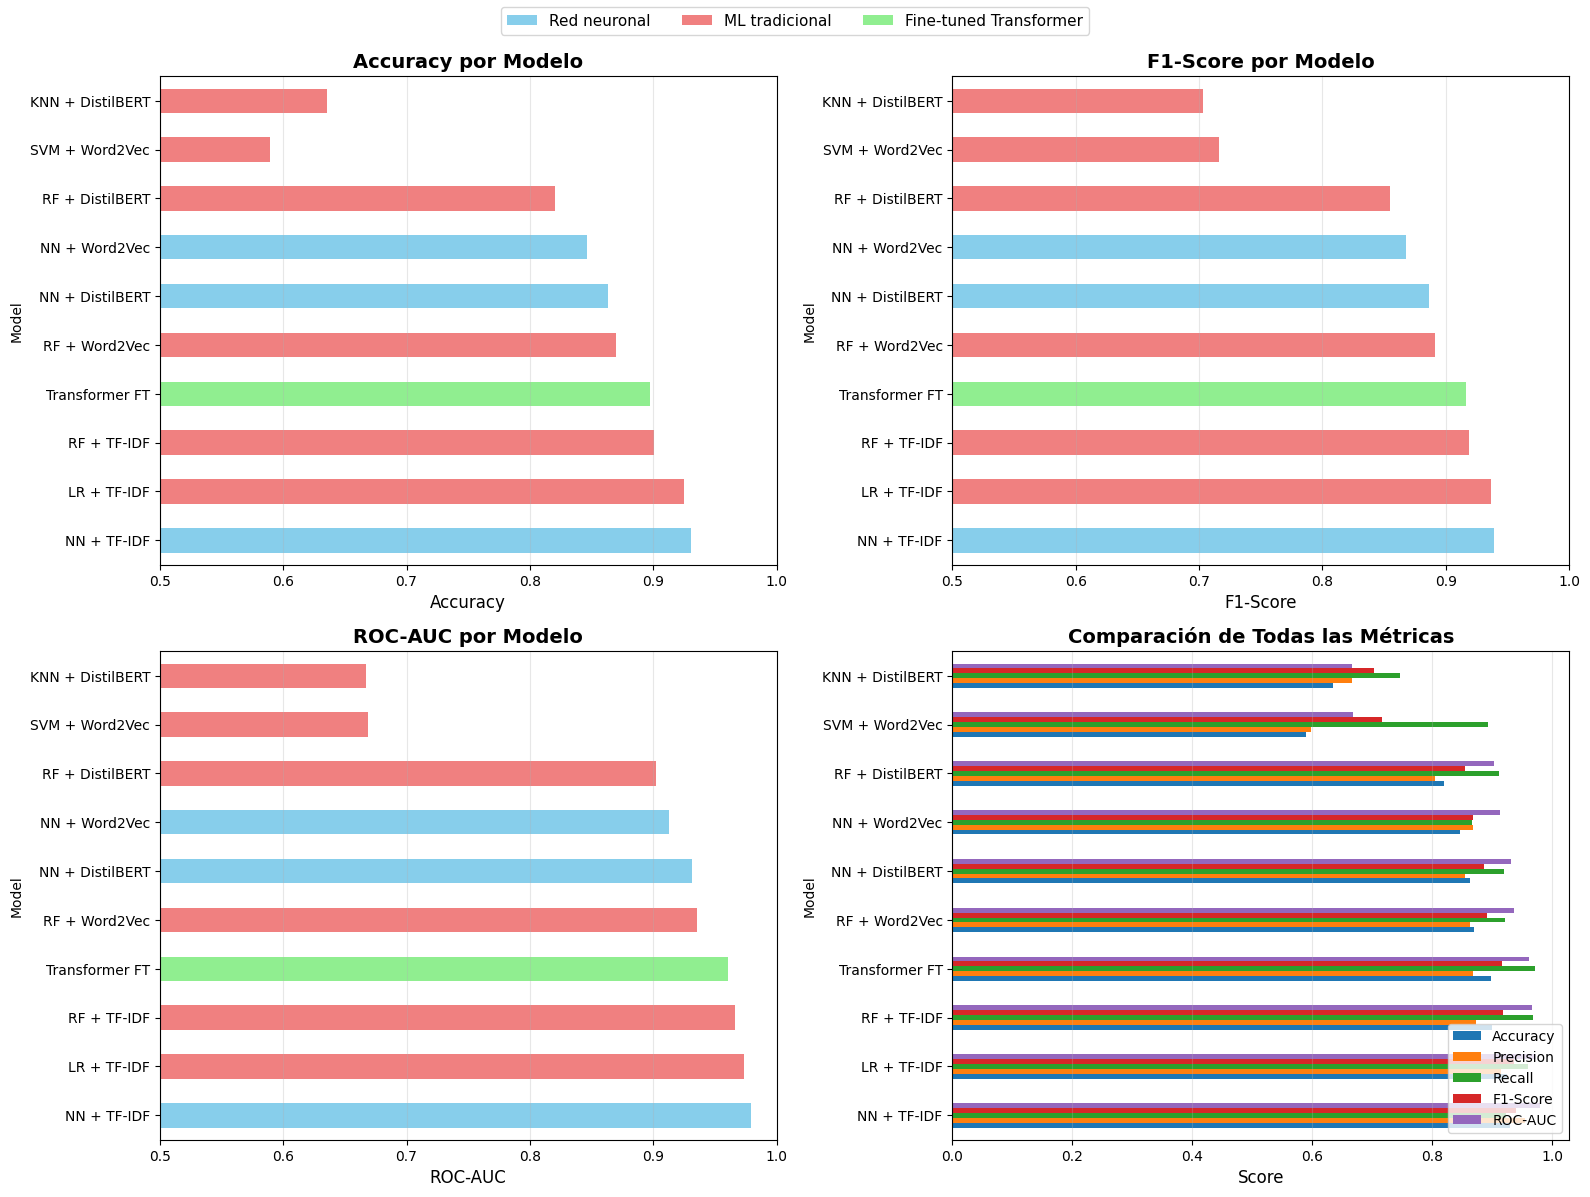

RESUMEN POR TIPO DE MODELO
                        Accuracy          F1-Score             ROC-AUC  \
                            mean     max      mean       max      mean   
Type                                                                     
Fine-tuned Transformer  0.897500  0.8975  0.916565  0.916565  0.960852   
ML tradicional          0.790083  0.9250  0.836882  0.936869  0.852272   
Red neuronal            0.880000  0.9305  0.897630  0.939062  0.941203   

                                  
                             max  
Type                              
Fine-tuned Transformer  0.960852  
ML tradicional          0.973847  
Red neuronal            0.979253  


In [ ]:
# Crear lista con todos los resultados
results = []

# Modelo 1: NN + TF-IDF
results.append({
    "Model": "NN + TF-IDF",
    "Type": "Red neuronal",
    "Accuracy": accuracy_score(tfidf_data['y_test'], y_test_pred),
    "Precision": precision_score(tfidf_data['y_test'], y_test_pred),
    "Recall": recall_score(tfidf_data['y_test'], y_test_pred),
    "F1-Score": f1_score(tfidf_data['y_test'], y_test_pred),
    "ROC-AUC": roc_auc_score(tfidf_data['y_test'], y_test_prob)
})

# Modelo 2: NN + Word2Vec
results.append({
    "Model": "NN + Word2Vec",
    "Type": "Red neuronal",
    "Accuracy": accuracy_score(w2v_data['y_test'], y_test_pred_w2v),
    "Precision": precision_score(w2v_data['y_test'], y_test_pred_w2v),
    "Recall": recall_score(w2v_data['y_test'], y_test_pred_w2v),
    "F1-Score": f1_score(w2v_data['y_test'], y_test_pred_w2v),
    "ROC-AUC": roc_auc_score(w2v_data['y_test'], y_test_prob_w2v.reshape(-1))
})

# Modelo 3: NN + DistilBERT
results.append({
    "Model": "NN + DistilBERT",
    "Type": "Red neuronal",
    "Accuracy": accuracy_score(bert_data['y_test'], y_test_pred_bert),
    "Precision": precision_score(bert_data['y_test'], y_test_pred_bert),
    "Recall": recall_score(bert_data['y_test'], y_test_pred_bert),
    "F1-Score": f1_score(bert_data['y_test'], y_test_pred_bert),
    "ROC-AUC": roc_auc_score(bert_data['y_test'], y_test_prob_bert.reshape(-1))
})

# Modelo 4: RF + TF-IDF
results.append({
    "Model": "RF + TF-IDF",
    "Type": "ML tradicional",
    "Accuracy": accuracy_score(tfidf_data['y_test'], pred_rf_tfidf),
    "Precision": precision_score(tfidf_data['y_test'], pred_rf_tfidf),
    "Recall": recall_score(tfidf_data['y_test'], pred_rf_tfidf),
    "F1-Score": f1_score(tfidf_data['y_test'], pred_rf_tfidf),
    "ROC-AUC": roc_auc_score(tfidf_data['y_test'], prob_rf_tfidf)
})

# Modelo 5: LR + TF-IDF
results.append({
    "Model": "LR + TF-IDF",
    "Type": "ML tradicional",
    "Accuracy": accuracy_score(tfidf_data['y_test'], pred_lr_tfidf),
    "Precision": precision_score(tfidf_data['y_test'], pred_lr_tfidf),
    "Recall": recall_score(tfidf_data['y_test'], pred_lr_tfidf),
    "F1-Score": f1_score(tfidf_data['y_test'], pred_lr_tfidf),
    "ROC-AUC": roc_auc_score(tfidf_data['y_test'], prob_lr_tfidf)
})

# Modelo 6: RF + Word2Vec
results.append({
    "Model": "RF + Word2Vec",
    "Type": "ML tradicional",
    "Accuracy": accuracy_score(w2v_data['y_test'], pred_rf_w2v),
    "Precision": precision_score(w2v_data['y_test'], pred_rf_w2v),
    "Recall": recall_score(w2v_data['y_test'], pred_rf_w2v),
    "F1-Score": f1_score(w2v_data['y_test'], pred_rf_w2v),
    "ROC-AUC": roc_auc_score(w2v_data['y_test'], prob_rf_w2v)
})

# Modelo 7: SVM + Word2Vec
results.append({
    "Model": "SVM + Word2Vec",
    "Type": "ML tradicional",
    "Accuracy": accuracy_score(w2v_data['y_test'], pred_svm_w2v),
    "Precision": precision_score(w2v_data['y_test'], pred_svm_w2v),
    "Recall": recall_score(w2v_data['y_test'], pred_svm_w2v),
    "F1-Score": f1_score(w2v_data['y_test'], pred_svm_w2v),
    "ROC-AUC": roc_auc_score(w2v_data['y_test'], prob_svm_w2v)
})

# Modelo 8: RF + DistilBERT
results.append({
    "Model": "RF + DistilBERT",
    "Type": "ML tradicional",
    "Accuracy": accuracy_score(bert_data['y_test'], pred_rf_bert),
    "Precision": precision_score(bert_data['y_test'], pred_rf_bert),
    "Recall": recall_score(bert_data['y_test'], pred_rf_bert),
    "F1-Score": f1_score(bert_data['y_test'], pred_rf_bert),
    "ROC-AUC": roc_auc_score(bert_data['y_test'], prob_rf_bert)
})

# Modelo 9: KNN + DistilBERT
results.append({
    "Model": "KNN + DistilBERT",
    "Type": "ML tradicional",
    "Accuracy": accuracy_score(bert_data['y_test'], pred_knn_bert),
    "Precision": precision_score(bert_data['y_test'], pred_knn_bert),
    "Recall": recall_score(bert_data['y_test'], pred_knn_bert),
    "F1-Score": f1_score(bert_data['y_test'], pred_knn_bert),
    "ROC-AUC": roc_auc_score(bert_data['y_test'], prob_knn_bert)
})

# Modelo 10: Transformer Fine-tuned
results.append({
    "Model": "Transformer FT",
    "Type": "Fine-tuned Transformer",
    "Accuracy": transformer_ft_results['metrics']['accuracy'],
    "Precision": transformer_ft_results['metrics']['precision'],
    "Recall": transformer_ft_results['metrics']['recall'],
    "F1-Score": transformer_ft_results['metrics']['f1'],
    "ROC-AUC": transformer_ft_results['metrics']['auc']
})

# Creamos DataFrame y ordenamos por F1-Score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("F1-Score", ascending=False)


print("TABLA COMPARATIVA COMPLETA DE TODOS LOS MODELOS")
print(results_df.to_string(index=False))

# Identificar el mejor modelo
best_model = results_df.iloc[0]
print(f"\nMEJOR MODELO: {best_model['Model']}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

# Visualización comparativa mejorada
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color por tipo de modelo
color_map = {
    'Red neuronal': 'skyblue',
    'ML tradicional': 'lightcoral',
    'Fine-tuned Transformer': 'lightgreen'
}
colors = results_df['Type'].map(color_map)

# 1. Accuracy
ax1 = axes[0,0]
results_df.plot(x="Model", y="Accuracy", kind="barh", ax=ax1, legend=False, color=colors)
ax1.set_title("Accuracy por Modelo", fontsize=14, fontweight='bold')
ax1.set_xlabel("Accuracy", fontsize=12)
ax1.set_xlim([0.5, 1.0])
ax1.grid(axis='x', alpha=0.3)

# 2. F1-Score
ax2 = axes[0,1]
results_df.plot(x="Model", y="F1-Score", kind="barh", ax=ax2, legend=False, color=colors)
ax2.set_title("F1-Score por Modelo", fontsize=14, fontweight='bold')
ax2.set_xlabel("F1-Score", fontsize=12)
ax2.set_xlim([0.5, 1.0])
ax2.grid(axis='x', alpha=0.3)

# 3. ROC-AUC
ax3 = axes[1,0]
results_df.plot(x="Model", y="ROC-AUC", kind="barh", ax=ax3, legend=False, color=colors)
ax3.set_title("ROC-AUC por Modelo", fontsize=14, fontweight='bold')
ax3.set_xlabel("ROC-AUC", fontsize=12)
ax3.set_xlim([0.5, 1.0])
ax3.grid(axis='x', alpha=0.3)

# 4. Comparación múltiple
ax4 = axes[1,1]
metrics_subset = results_df[["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]].set_index("Model")
metrics_subset.plot(kind="barh", ax=ax4)
ax4.set_title("Comparación de Todas las Métricas", fontsize=14, fontweight='bold')
ax4.set_xlabel("Score", fontsize=12)
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(axis='x', alpha=0.3)

# Leyenda de colores
legend_elements = [
    Patch(facecolor='skyblue', label='Red neuronal'),
    Patch(facecolor='lightcoral', label='ML tradicional'),
    Patch(facecolor='lightgreen', label='Fine-tuned Transformer')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Tabla resumida por tipo de modelo
print("RESUMEN POR TIPO DE MODELO")
summary = results_df.groupby('Type')[['Accuracy', 'F1-Score', 'ROC-AUC']].agg(['mean', 'max'])
print(summary)

### Interpretación de Hipótesis

       title_len     text_len    total_len
label                                     
0      70.743571  5212.669524  5283.413095
1      85.809483  5385.468793  5471.278276


       punctuation_count  uppercase_ratio
label                                    
0             118.184762         0.032651
1             124.692241         0.036788


       numerical_count
label                 
0            29.093095
1            35.700862


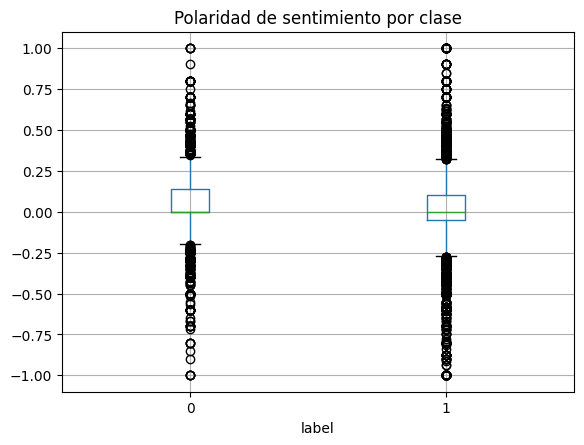

In [ ]:
# Vamos a visualizar varios parámetros para poder suponer varias hipótesis, orientados pot los apartados anteriores
# Sacamos las medias de longitud por clase
print(df.groupby("label")[["title_len", "text_len", "total_len"]].mean())
print("\n")

# Igual que en el caso anterior pero con las mayúsculas y signos de puntuación
print(df.groupby("label")[["punctuation_count", "uppercase_ratio"]].mean())
print("\n")

# Igual que en el caso anterior pero con el número de valores numéricos
print(df.groupby("label")[["numerical_count"]].mean())

# Distribución de la polaridad de sentimiento según sean noticias verdaderas o falsas
df.boxplot(column="sentiment_polarity", by="label")
plt.title("Polaridad de sentimiento por clase")
plt.suptitle("")
plt.show()

**Hipótesis 1 — Mayor carga emocional en contenido desinformativo**

Los textos que han sido etiquetados con label = 1 (Fake News) tienden a estar en valores extremos en el valor de sentimiento político (más próximos a -1 y 1). Podemos observar una ligera presencia de esos valores extremos en la etiqueta 1.


**Hipótesis 2 — Mayor uso de signos de puntuación y letras en mayúscula en textos falsos**

Las noticias falsas (label = 1, Fake News) tienden a usar más signos de puntuación y letras en mayúscula, buscando ese impacto mencionado en la hipótesis planteada en el espectador.

**Hipótesis 3 — Exceso de número de palabras en textos falsos**

Observamos que en las Fake News (label = 1) hay un número muy alto de palabras, con una posible intención de justificación rebuscada sobre datos falsos. Se puede ver comparando los parámetros text_len (número de palabras del texto), title_len (número de palabras del texto) y total_len (número de palabras combinadas entre el título y el texto).

**Hipótesis 4 — Mayor uso de datos numéricos en Fake News**

Las Fake News (label = 1) tienden a incluir más números y porcentajes que las noticias reales, demostrando nuestro planteamiento inicial de posible justificación mediante valores numéricos.

# 5. EXTENSIÓN DE PROYECTO

# 5.1. Análisis temático de la desinformación

Shape embeddings: (2000, 768)
Shape numéricas extra: (2000, 4)
KMeans listo. K=8 | Silhouette (aprox): 0.0362

Estadísticas por cluster (ordenado por %Fake):
           n  fake_rate  mean_sent  mean_punct  mean_upper  mean_nums
cluster                                                              
7        348   0.870690  -0.016221  137.181034    0.037636  33.867816
5        247   0.696356  -0.007784  111.477733    0.035875  30.485830
0        212   0.693396  -0.003687  156.231132    0.027976  51.495283
3        246   0.597561   0.050654  173.134146    0.031759  46.589431
1        277   0.566787   0.017898  108.953069    0.040486  30.509025
2        316   0.452532   0.050380  112.759494    0.033601  36.696203
6        163   0.288344   0.030190  103.325153    0.034960  28.822086
4        191   0.230366   0.027889  101.471204    0.037201  25.146597

Top términos por cluster:
Cluster 7 | fake_rate=0.871 | top_terms=['trump', 'clinton', 'hillary', 'obama', 'people', 'donald', 'donald trump'

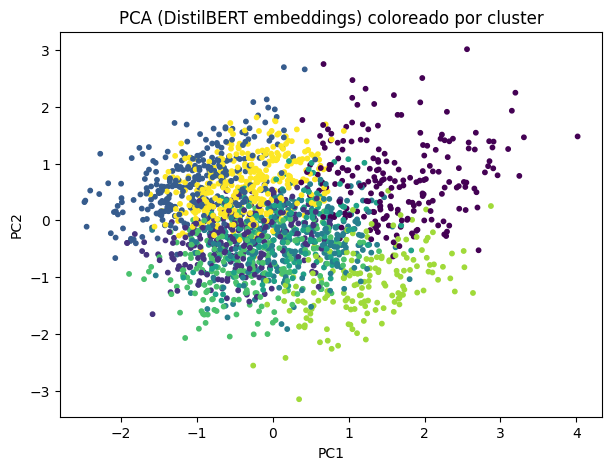

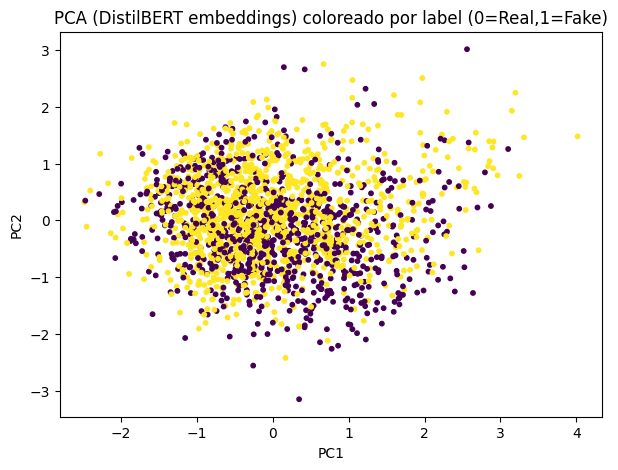


Conclusión:
- Cluster con más %Fake: 7 (fake_rate=0.871)
  Términos representativos: ['trump', 'clinton', 'hillary', 'obama', 'people', 'donald', 'donald trump', 'president', 'republican', 'american']
- Cluster con menos %Fake: 4 (fake_rate=0.230)
  Términos representativos: ['trump', 'said', 'state', 'china', 'president', 'russia', 'united', 'minister', 'trade', 'eu']


In [ ]:
# En este bloque de extensión, hacemos un análisis para entender qué temas aparecen en los textos y como se relacionan con la desinformación y la polarización.
# Para ello, usamos los embbedings contextuales de DistilBERT del conjunto de TEST para agrupar los textos en clusters temáticos, para después analizar qué porcentaje de noticias falsas contiene,
# qué palabras lo caracterizan y cómo se comporta en general

# Preparamos los embeddings de DistilBERT del conjunto de TEST
X_test_bert_sparse = bert_data["X_test"]
X_test_bert_all = X_test_bert_sparse.toarray()

# Separamos los embbedings de las características adicionales
EMB_DIM = 768
X_test_bert_emb = X_test_bert_all[:, :EMB_DIM]
X_test_num_extra = X_test_bert_all[:, EMB_DIM:]  # Características --> [punctuation_count, uppercase_ratio, numerical_count, sentiment_polarity]

y_test_ext = np.array(bert_data["y_test"])

print("Shape embeddings:", X_test_bert_emb.shape)
print("Shape numéricas extra:", X_test_num_extra.shape)

# Recuperamos los textos originales del conjunto de TEST
texts_test = X_test_text.tolist()

# Realizamos el clustering con KMeans sobre los embeddings
K = 8
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_test_bert_emb)

# Realizamos una métrica orientativa de calidad del clustering
try:
    sil = silhouette_score(X_test_bert_emb, clusters)
except Exception:
    sil = np.nan

print(f"KMeans listo. K={K} | Silhouette (aprox): {sil:.4f}")

# Creamos un DataFrame de análisis por cada cluster
df_ext = pd.DataFrame({
    "text": texts_test,
    "label": y_test_ext,               # 0=Real, 1=Fake
    "cluster": clusters,
    "punctuation_count": X_test_num_extra[:, 0],
    "uppercase_ratio":    X_test_num_extra[:, 1],
    "numerical_count":    X_test_num_extra[:, 2],
    "sentiment_polarity": X_test_num_extra[:, 3],
})

# Proporción de fake por cluster
cluster_stats = df_ext.groupby("cluster").agg(
    n=("label", "count"),
    fake_rate=("label", "mean"),
    mean_sent=("sentiment_polarity", "mean"),
    mean_punct=("punctuation_count", "mean"),
    mean_upper=("uppercase_ratio", "mean"),
    mean_nums=("numerical_count", "mean"),
).sort_values("fake_rate", ascending=False)

print("\nEstadísticas por cluster (ordenado por %Fake):")
print(cluster_stats)

# Palabras representativas por cluster
tfidf_cluster_vec = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=3,
    stop_words="english"
)

X_tfidf_test_cluster = tfidf_cluster_vec.fit_transform(df_ext["text"].astype(str))
vocab = np.array(tfidf_cluster_vec.get_feature_names_out())

TOPN = 10
top_terms_by_cluster = {}

for c in range(K):
    idx = np.where(df_ext["cluster"].values == c)[0]
    if len(idx) == 0:
        top_terms_by_cluster[c] = []
        continue

    # TF-IDF medio del cluster
    mean_tfidf = X_tfidf_test_cluster[idx].mean(axis=0)
    mean_tfidf = np.asarray(mean_tfidf).ravel()

    top_idx = mean_tfidf.argsort()[::-1][:TOPN]
    top_terms = vocab[top_idx].tolist()
    top_terms_by_cluster[c] = top_terms

print("\nTop términos por cluster:")
for c in cluster_stats.index:
    print(f"Cluster {c} | fake_rate={cluster_stats.loc[c, 'fake_rate']:.3f} | top_terms={top_terms_by_cluster[c]}")


# Visualización en proyección 2D (PCA) coloreada por cluster y por label
# La figura mostrará una proyección de los embbedings contextuales de DistilBERT, donde cada punto representa un texto. PC1 y PC2 corresponden a combinaciones de las características
# semánticas del texto

print("\nVisualización 2D con PCA...")
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_test_bert_emb)

# En la primera gráfica, los colores muestra los clusters temáticos obtenidos con K-means
plt.figure(figsize=(7,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, s=10)
plt.title("PCA (DistilBERT embeddings) coloreado por cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# En la segunda gráfica, los puntos se colorean según la etiqueta real (real --> 0, fake --> 1)
plt.figure(figsize=(7,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_test_ext, s=10)
plt.title("PCA (DistilBERT embeddings) coloreado por label (0=Real,1=Fake)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Conclusión
print("\nConclusión:")
c_max = cluster_stats.index[0]
c_min = cluster_stats.index[-1]

print(f"- Cluster con más %Fake: {c_max} (fake_rate={cluster_stats.loc[c_max, 'fake_rate']:.3f})")
print(f"  Términos representativos: {top_terms_by_cluster[c_max]}")
print(f"- Cluster con menos %Fake: {c_min} (fake_rate={cluster_stats.loc[c_min, 'fake_rate']:.3f})")
print(f"  Términos representativos: {top_terms_by_cluster[c_min]}")


# 5.2. Análisis de incertidumbre del modelo y detección de zonas “grises” de desinformación


Estadísticas por nivel de confianza:
                    n  fake_rate  mean_sent  mean_punct  mean_upper  mean_nums
confidence_group                                                              
Alta confianza    680   0.552941  -0.014333  111.130882    0.036243  36.285294
Baja confianza    660   0.525758   0.042402  142.771212    0.033062  35.478788
Confianza media   660   0.662121   0.025754  126.095455    0.036170  35.078788


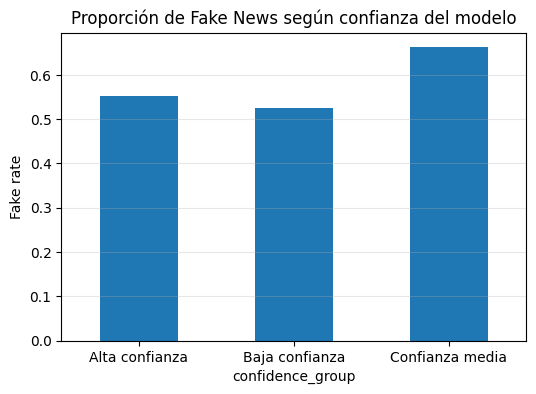

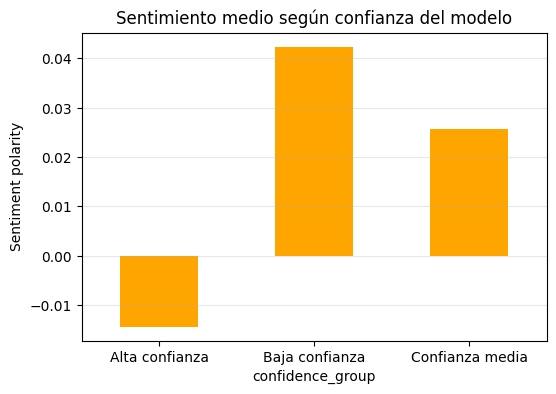


Ejemplos de textos con BAJA confianza (zona gris):
- Prob: 0.73170286 | Label: 0
  movement growing bring together woman across race creed political belief luring social medium arranging meet person nice idea one catch woman march washington organized facebook nation preferred platf ...

- Prob: 0.5868173 | Label: 1
  patrick henningsen 21st century wireso far world peace prosperity go name currently kicked around america top diplomatic position inspire great deal confidence easy feel uneasy see recycled neoconserv ...

- Prob: 0.87759364 | Label: 1
  posted michael snyder realize headline must sound extremely bizarre article explain could actually happen learned fbi obtained search warrant enable agency examine approximately email sitting electron ...

- Prob: 0.85362875 | Label: 0
  vise appears tightening education giant itt educational service profit collapsing stock 2 last monday company got bad news education department washington main overseer itt operates 138 campus 39 stat ..

In [ ]:
# En esta parte, analizamos la incertidumbre del modelo NN + DistilBERT a partir de sus probabilidades de predicción. Clasificamos los textos en grupos de alta y baja confianza en función de la
# seguridad que tiene el modelo en su predicción (alta confianza -> cerca de 0 o 1, baja confianza -> cerca de 0.5) para poder medir la desinformación y la polaridad según la confianza del modelo


# Usamos las probabilidades del modelo NN + DistilBERT
probs = y_test_prob_bert.reshape(-1)
labels = np.array(bert_data["y_test"])

# Medida de confianza (distancia a 0.5)
confidence = np.abs(probs - 0.5)

# Creamos un DataFrame para el análisis
df_unc = pd.DataFrame({
    "prob": probs,
    "label": labels,
    "confidence": confidence,
    "sentiment": X_test_num_extra[:, 3],
    "punctuation": X_test_num_extra[:, 0],
    "uppercase": X_test_num_extra[:, 1],
    "numbers": X_test_num_extra[:, 2],
})

# Definimos los umbrales de confianza
low_thr  = np.quantile(confidence, 0.33)
high_thr = np.quantile(confidence, 0.66)

def confidence_group(c):
    if c <= low_thr:
        return "Baja confianza"
    elif c <= high_thr:
        return "Confianza media"
    else:
        return "Alta confianza"

df_unc["confidence_group"] = df_unc["confidence"].apply(confidence_group)

# Estadísticas de cada grupo de confianza
group_stats = df_unc.groupby("confidence_group").agg(
    n=("label", "count"),
    fake_rate=("label", "mean"),
    mean_sent=("sentiment", "mean"),
    mean_punct=("punctuation", "mean"),
    mean_upper=("uppercase", "mean"),
    mean_nums=("numbers", "mean")
)

print("\nEstadísticas por nivel de confianza:")
print(group_stats)

# En la primera gráfica, mostramos el porcentaje de noticias falsas de cada uno delos grupos de confianza en los que clasificamos los textos
plt.figure(figsize=(6,4))
group_stats["fake_rate"].plot(kind="bar")
plt.title("Proporción de Fake News según confianza del modelo")
plt.ylabel("Fake rate")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()

# En la segunda gráfica, mostramos el sentimiento medio de cada uno de los grupos de confianza en los que clasificamos los textos
plt.figure(figsize=(6,4))
group_stats["mean_sent"].plot(kind="bar", color="orange")
plt.title("Sentimiento medio según confianza del modelo")
plt.ylabel("Sentiment polarity")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()


# Proporcionamos algunos jemplos de textos con baja confianza (zona gris)
print("\nEjemplos de textos con BAJA confianza (zona gris):")

idx_low_conf = df_unc[df_unc["confidence_group"] == "Baja confianza"].index[:5]
for i in idx_low_conf:
    print("- Prob:", probs[i], "| Label:", labels[i])
    print(" ", texts_test[i][:200], "...\n")


# 5.3. Análisis correlacional de la polarización


Matriz de correlación:
                 fake  sentiment  punctuation  uppercase   numbers  confidence
fake         1.000000  -0.111323     0.040820   0.177738  0.070283    0.069734
sentiment   -0.111323   1.000000     0.007394  -0.024264 -0.012435   -0.067260
punctuation  0.040820   0.007394     1.000000   0.045027  0.654260   -0.078432
uppercase    0.177738  -0.024264     0.045027   1.000000  0.200946    0.093632
numbers      0.070283  -0.012435     0.654260   0.200946  1.000000    0.007988
confidence   0.069734  -0.067260    -0.078432   0.093632  0.007988    1.000000


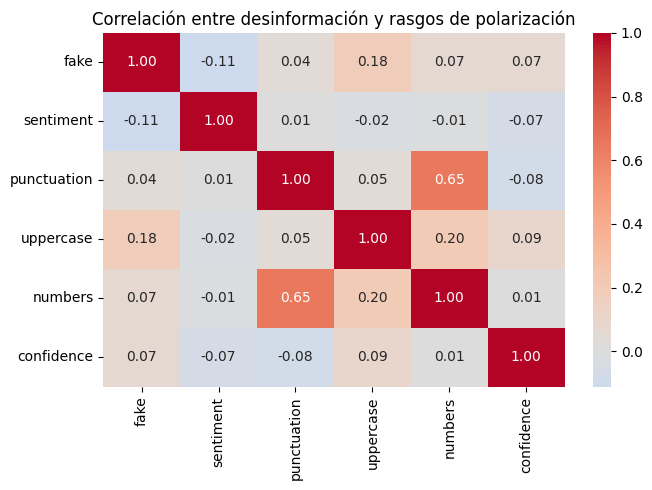


[EXT-CORR] Medias por clase (0=Real, 1=Fake):
      sentiment  punctuation  uppercase    numbers  confidence
fake                                                          
0      0.050577   119.971429   0.032488  30.276190    0.372578
1     -0.006248   131.245690   0.037111  39.491379    0.390756


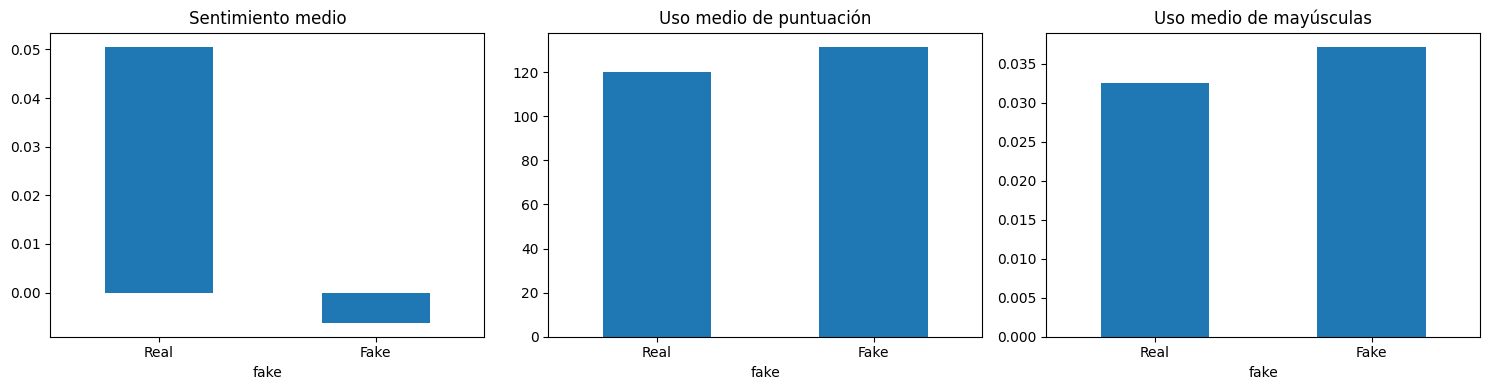


Conclusión:
- Valores positivos indican mayor asociación con contenido Fake.
- Se observa que la desinformación tiende a presentar mayor carga emocional y rasgos lingüísticos más polarizados.
- La correlación con la confianza del modelo sugiere que estos textos también son más difíciles de clasificar.


In [ ]:
# En este bloque realizamos un análisis correlacional de la polarización linguística sobre el conjunto de test. A través de las etiquetas reales y de varias características del texto
# calculamos una matriz de correlación para estudiar como se relacionan las variables entre sí. El objetivo es identificar si el contenido desinformativo presenta patrones lingüísticos
# más polarizados y si estos influyen en la dificultad de clasificación del modelo.

# Construimos el DataFrame con variables relevantes
df_corr = pd.DataFrame({
    "fake": y_test_ext,  # 0=Real, 1=Fake
    "sentiment": X_test_num_extra[:, 3],
    "punctuation": X_test_num_extra[:, 0],
    "uppercase": X_test_num_extra[:, 1],
    "numbers": X_test_num_extra[:, 2],
    "confidence": np.abs(y_test_prob_bert.reshape(-1) - 0.5)  # confianza del modelo
})

# Correlaciones
corr_matrix = df_corr.corr()

print("\nMatriz de correlación:")
print(corr_matrix)

# Heatmap de correlaciones
plt.figure(figsize=(7,5))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlación entre desinformación y rasgos de polarización")
plt.tight_layout()
plt.show()

# Hacemos una comparación directa: Real vs Fake
group_means = df_corr.groupby("fake").mean()

print("\n[EXT-CORR] Medias por clase (0=Real, 1=Fake):")
print(group_means)

# Mostramos una comparativa
fig, axes = plt.subplots(1, 3, figsize=(15,4))

# Gráfica de sentimiento medio real vs fake
group_means[["sentiment"]].plot(kind="bar", ax=axes[0], legend=False)
axes[0].set_title("Sentimiento medio")
axes[0].set_xticklabels(["Real", "Fake"], rotation=0)

# Gráfica de uso de puntuación media real vs fake
group_means[["punctuation"]].plot(kind="bar", ax=axes[1], legend=False)
axes[1].set_title("Uso medio de puntuación")
axes[1].set_xticklabels(["Real", "Fake"], rotation=0)

# Gráfcia de uso medio de mayúsculas real vs fake
group_means[["uppercase"]].plot(kind="bar", ax=axes[2], legend=False)
axes[2].set_title("Uso medio de mayúsculas")
axes[2].set_xticklabels(["Real", "Fake"], rotation=0)

plt.tight_layout()
plt.show()

# 7.4 Conclusión
print("\nConclusión:")
print("- Valores positivos indican mayor asociación con contenido Fake.")
print("- Se observa que la desinformación tiende a presentar mayor carga emocional y rasgos lingüísticos más polarizados.")
print("- La correlación con la confianza del modelo sugiere que estos textos también son más difíciles de clasificar.")
